# Hypothesis Analysis

## Setup environment

### Import Packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pathlib
import sys

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import pandas as pd
import ruptures as rpt

from smart_simulation.cfg_templates.config import package_dir

### Connect to data

In [3]:
# Get path to raw weights data
raw_data_path = (
    pathlib.Path(package_dir) / "smart_simulation/outputs/simulations/weights"
)

# List all weights files
flist = [p for p in raw_data_path.iterdir() if p.is_file()]

## Sample EDA

### Raw Data Visualization

In [4]:
# Get sample
sample = pd.read_csv(flist[0], parse_dates=True, index_col=0)
sample.head()

,weight
2020-01-01 00:00:00,14.000000
2020-01-01 06:00:00,13.601856
2020-01-01 12:00:00,13.601856
2020-01-01 18:00:00,13.601856
2020-01-02 00:00:00,13.144815


In [5]:
def plot_weights(dates, weights, title, sample_label, bar=False):
    
    dates_array_shape = dates.shape
    weights_array_shape = weights.shape
    
    if len(dates_array_shape) != 1:
        dates = dates.reshape(-1)
    if len(weights_array_shape) != 1:
        weights = weights.reshape(-1)
    
    days = mdates.WeekdayLocator()
    months = mdates.MonthLocator()
    years = mdates.YearLocator()  
    months_fmt = mdates.DateFormatter('%m')
    
    fig, ax = plt.subplots(figsize=(18, 6))
    
    if bar:
        ax.bar(dates, weights, label=sample_label)
    else:
        ax.plot(dates, weights, label = sample_label)

    locator = mdates.AutoDateLocator()
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.set(xlabel='Date', ylabel='Weight (oz)', title=title)
    ax.legend()


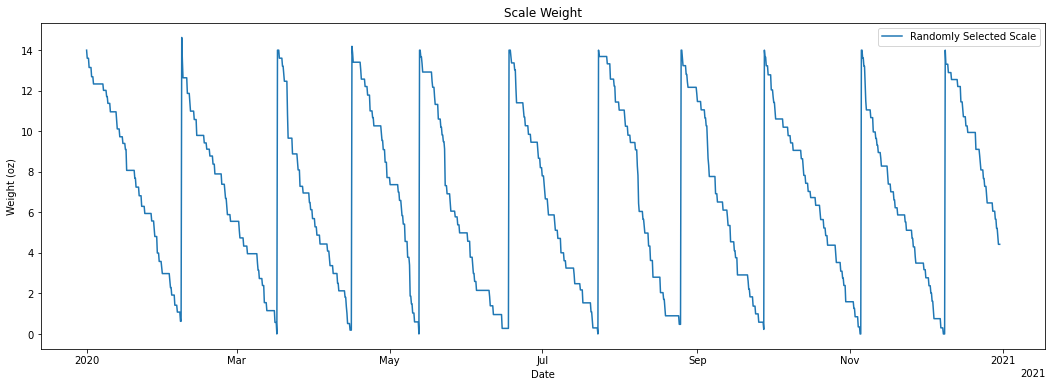

In [6]:
plot_weights(sample.index, sample.values, 'Scale Weight', 'Randomly Selected Scale', bar = False)

### Consumption


In [7]:
raw_consumption = -1 * sample.weight.diff()

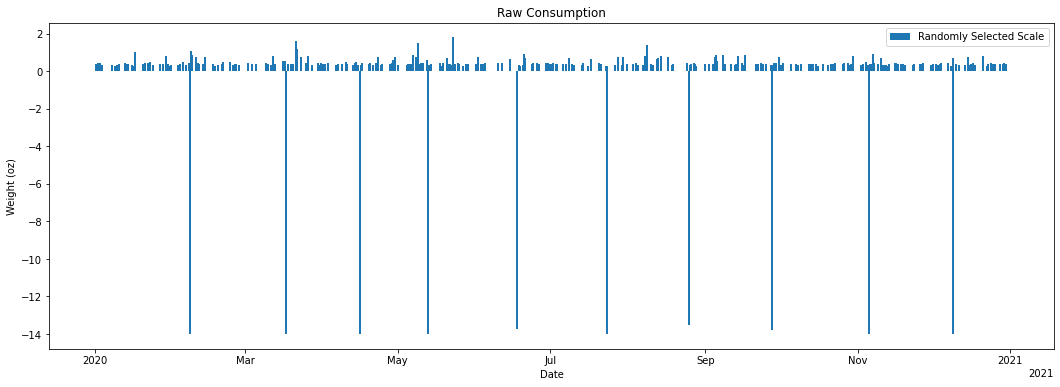

In [8]:
plot_weights(raw_consumption.index, raw_consumption.values, 'Raw Consumption', 'Randomly Selected Scale', bar = True)

#### Raw Frequency Analysis

In [9]:
def calculate_consumption(weight_data):
    raw_consumption = -1 * weight_data.diff()
    raw_consumption.loc[raw_consumption == -0] = 0 # prior transform converts 0 to -0
    with_new_product = raw_consumption.copy()
    with_new_product.loc[raw_consumption < 0] += 14
    return with_new_product

In [10]:
clean_consumption = calculate_consumption(sample.weight)

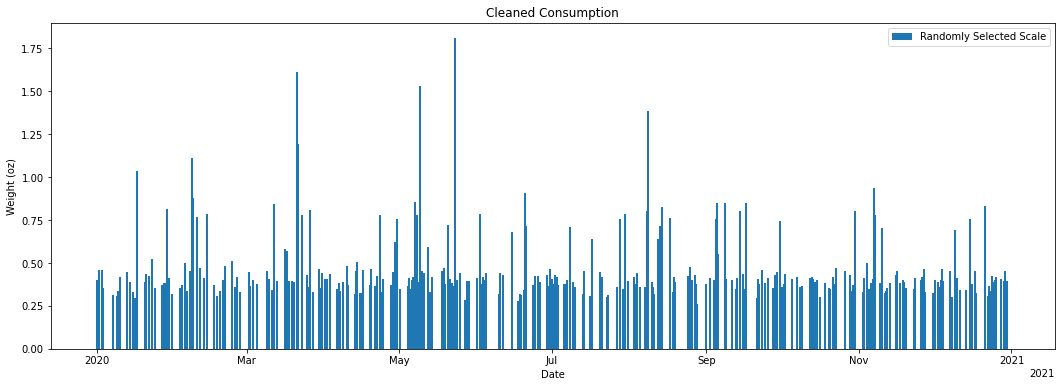

In [11]:
plot_weights(clean_consumption.index, clean_consumption.values, 'Cleaned Consumption', 'Randomly Selected Scale', bar = True)

#### Daily Frequency Analysis

In [12]:
daily_consumption = clean_consumption.resample('1D').sum()

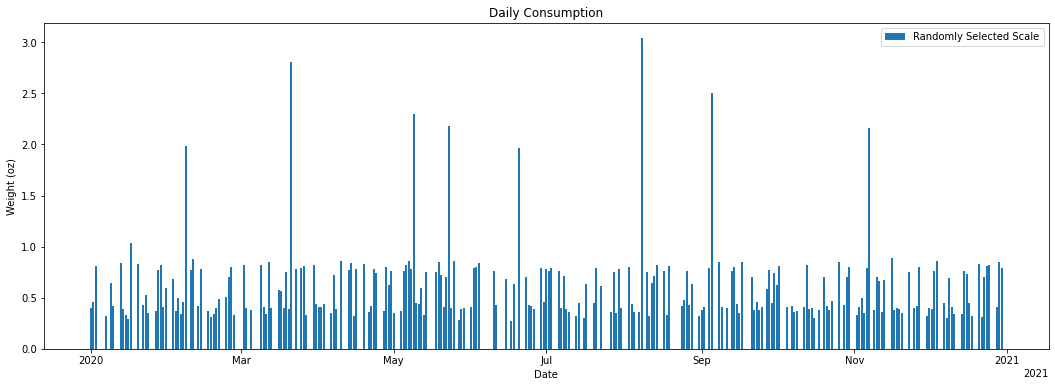

In [13]:
plot_weights(daily_consumption.index, daily_consumption.values, 'Daily Consumption', 'Randomly Selected Scale', bar = True)

#### Day of Week Analysis

In [14]:
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
day_of_week_mean = clean_consumption.groupby(clean_consumption.index.day_name()).mean().reindex(days)
groups_by_day_of_week = clean_consumption.groupby(clean_consumption.index.day_name())

data_with_dow = daily_consumption.copy().to_frame("consumption")
data_with_dow["day_of_week"] = data_with_dow.index.day_name()

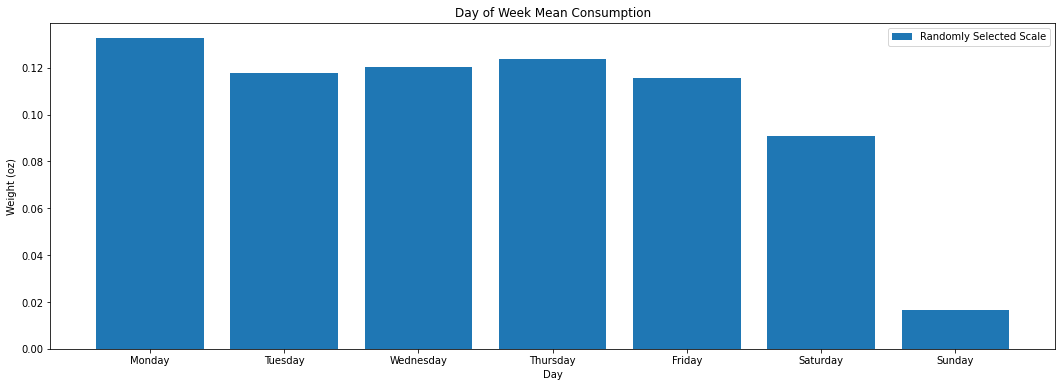

In [15]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.bar(day_of_week_mean.index, day_of_week_mean.values, label='Randomly Selected Scale')
ax.set(xlabel='Day', ylabel='Weight (oz)', title='Day of Week Mean Consumption')
ax.legend()

Text(0.5, 0.98, 'Consumption Distribution of [Sample] by Day of Week')

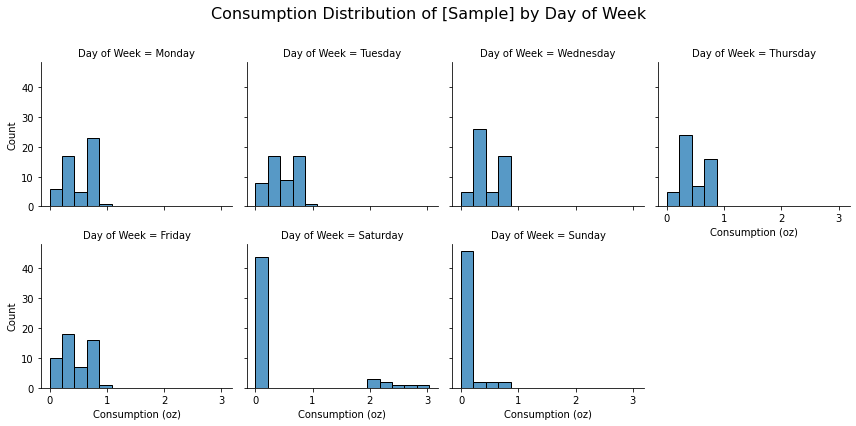

In [56]:
bins=np.linspace(data_with_dow['consumption'].min(), data_with_dow['consumption'].max(), 15)
ax = sns.displot(data_with_dow, x="consumption", col="day_of_week",col_wrap = 4, bins = bins, height=3, aspect=1, facet_kws=dict(col_order=days),)
ax.set_axis_labels("Consumption (oz)", "Count")
ax.set_titles(col_template="Day of Week = {col_name}")
ax.fig.subplots_adjust(top=0.85)
ax.fig.suptitle('Consumption Distribution of [Sample] by Day of Week', fontsize=16)

[Text(0.5, 0, 'Day of Week'),
 Text(0, 0.5, 'Consumption (oz)'),
 Text(0.5, 1.0, 'Consumption analysis of [Sample] by Day of Week')]

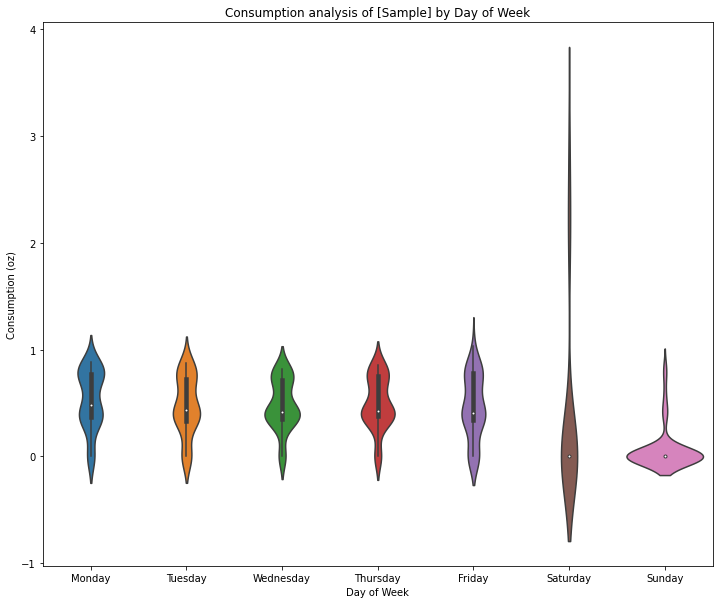

In [58]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = sns.violinplot(x="day_of_week", y="consumption", data=data_with_dow, order=days)
ax.set(xlabel="Day of Week", ylabel="Consumption (oz)", title = 'Consumption analysis of [Sample] by Day of Week')

#### Product Periods

THIS SECTION IS INCOMPLETE.

Objective: Identify change points (resupply dates) to segment into individual product consumption periods.

In [59]:
import ruptures as rpt

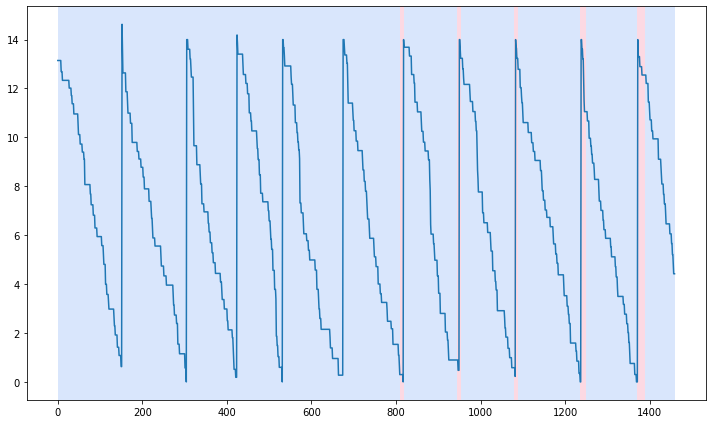

In [66]:
data = sample.values
# change point detection
model = "ar"  # "l1", "rbf", "linear", "normal", "ar"
algo = rpt.Binseg(model=model).fit(data)
my_bkps = algo.predict(n_bkps=10)

# show results
rpt.show.display(data, my_bkps, figsize=(10, 6))
plt.show()

## Full Training Dataset EDA